In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('drought_training_df_without_outliers.xlsx')

training_df.head()

,339,341,342,344,345,346,348,349,351,352,...,2499,2501,2503,2505,2507,2509,2511,2514,2516,Water Potential (Mpa)
0,0.1481,0.1818,0.1748,0.1486,0.1045,0.0782,0.0904,0.0830,0.1101,0.1168,...,0.0332,0.0347,0.0323,0.0308,0.0360,0.0346,0.0320,0.0328,0.0344,-0.089632
1,0.1422,0.1360,0.1384,0.1283,0.1103,0.0967,0.1014,0.1040,0.0934,0.0819,...,0.0560,0.0589,0.0560,0.0551,0.0563,0.0554,0.0533,0.0547,0.0528,-0.148237
2,0.0978,0.0920,0.1038,0.0981,0.0793,0.0613,0.0477,0.0520,0.0545,0.0698,...,0.0280,0.0252,0.0269,0.0275,0.0293,0.0311,0.0284,0.0279,0.0294,-0.128243
3,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,0.0722,...,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479,-0.164785
4,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:24:12,741] A new study created in memory with name: no-name-efc23c04-13d8-433b-aa03-32da0ca4147b
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:13,665] Trial 0 finished with value: 3.5678520198910673 and parameters: {'n_components': 939, 'max_iter': 518}. Best is trial 0 with value: 3.5678520198910673.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:13,702] Trial 1 finished with value: 3.567852019891077 and parameters: {'n_components': 192, 'max_iter': 624}. Best is trial 0 with value: 3.5678520198910673.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning:

[I 2024-03-07 15:24:24,969] Trial 22 finished with value: 3.5752429731360693 and parameters: {'n_components': 19, 'max_iter': 202}. Best is trial 20 with value: 3.5104960907918183.
[I 2024-03-07 15:24:24,990] Trial 23 finished with value: 3.2555758060240216 and parameters: {'n_components': 14, 'max_iter': 226}. Best is trial 23 with value: 3.2555758060240216.
[I 2024-03-07 15:24:25,008] Trial 24 finished with value: 2.143533358235588 and parameters: {'n_components': 3, 'max_iter': 233}. Best is trial 24 with value: 2.143533358235588.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:25,048] Trial 25 finished with value: 3.5678520198911143 and parameters: {'n_components': 127, 'max_iter': 297}. Best is trial 24 with value: 2.143533358235588.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:26,027] Trial 48 finished with value: 3.5678520198910832 and parameters: {'n_components': 153, 'max_iter': 270}. Best is trial 24 with value: 2.143533358235588.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:26,136] Trial 49 finished with value: 3.5678520198910975 and parameters: {'n_components': 397, 'max_iter': 995}. Best is trial 24 with value: 2.143533358235588.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:27,658] Trial 75 finished with value: 3.5678520198911112 and parameters: {'n_components': 106, 'max_iter': 197}. Best is trial 24 with value: 2.143533358235588.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 45
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:24:27,715] Trial 76 finished with value: 3.567852019891102 and parameters: {'n_components': 58, 'max_iter': 248}. Best is trial 24 with value: 2.143533358235588.
[I 2024-03-07 15:24:27,747] Trial 77 finished with value: 3.56740070465905 and parameters: {'n_components': 1, 'max_iter': 123}. Best is trial 24 with value: 2.143533358235588.
[I 2024-03-07 15:24:27,794] Trial 78 finished

Number of finished trials:  100
Best trial:
  Value: 2.143533358235588
  Params: 
    n_components: 3
    max_iter: 233
Mean Squared Error: 2.143533358235588
Root Mean Squared Error: 1.4640810627269203
R-Squared value: 0.4675203559567087


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
1894: -0.007764860154380222
1898: -0.007750037944648446
1891: -0.007678252590615779


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:24:30,669] A new study created in memory with name: no-name-8f74f4be-0278-4a86-becc-0d665651e426
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:30,693] Trial 0 finished with value: 4.6411554749318675 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 4.6411554749318675.
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:31,006] Trial 9 finished with value: 2.5768167000758697 and parameters: {'alpha': 0.47841987416050147, 'l1_ratio': 0.17893744751587604, 'max_iter': 913}. Best is trial 2 with value: 2.4626690500396236.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:31,396] Trial 17 finished with value: 2.464657509893802 and parameters: {'alpha': 0.10015015694811372, 'l1_ratio': 0.774717211715258, 'max_iter': 305}. Best is trial 14 with value: 2.340824657571569.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated i

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:31,873] Trial 26 finished with value: 2.6124288276950156 and parameters: {'alpha': 0.19199657128446512, 'l1_ratio': 0.516692740968792, 'max_iter': 804}. Best is trial 21 with value: 2.3055698574653682.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:32,518] Trial 36 finished with value: 2.9009942506253386 and parameters: {'alpha': 0.2317688700083337, 'l1_ratio': 0.6829814223772516, 'max_iter': 668}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:33,043] Trial 45 finished with value: 3.2140129694066224 and parameters: {'alpha': 0.29732189984870905, 'l1_ratio': 0.7257608225976745, 'max_iter': 611}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:33,689] Trial 54 finished with value: 4.890700310739524 and parameters: {'alpha': 0.6578746223465886, 'l1_ratio': 0.7412025997009124, 'max_iter': 777}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated i

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:34,390] Trial 63 finished with value: 2.330360164852502 and parameters: {'alpha': 0.07015436412781617, 'l1_ratio': 0.6030864520060999, 'max_iter': 557}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 6.230e-03
  model = cd_fast.enet_coordinate_descent(
[I 2024-03-07 15:24:34,909] Trial 71 finished with value: 2.370537722812786 and parameters: {'alpha': 0.4123139913100786, 'l1_ratio': 0.05960185929181014, 'max_iter': 426}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarnin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:24:35,490] Trial 80 finished with value: 2.536599790389451 and parameters: {'alpha': 0.4999173066512553, 'l1_ratio': 0.15542703579431544, 'max_iter': 477}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

[I 2024-03-07 15:24:36,210] Trial 88 finished with value: 2.8169484432805696 and parameters: {'alpha': 0.9127539342663464, 'l1_ratio': 0.13504344018537331, 'max_iter': 377}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objecti

[I 2024-03-07 15:24:36,863] Trial 97 finished with value: 2.9290513389169157 and parameters: {'alpha': 0.49697838666927663, 'l1_ratio': 0.29848477684900304, 'max_iter': 537}. Best is trial 32 with value: 2.301167122591775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Object

Number of finished trials:  100
Best trial:
  Value: 2.301167122591775
  Params: 
    alpha: 0.08210487035143554
    l1_ratio: 0.6825703099612815
    max_iter: 665
Mean Squared Error: 2.301167122591775
Root Mean Squared Error: 1.5169598289314634
R-Squared value: 0.42836221997011625


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
1891: -0.27581072239416926
1894: -0.24080779994300103
386: -0.23652973606425418


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:24:37,133] A new study created in memory with name: no-name-75e6e3cd-ba3f-4f90-81d9-c0cf386a660b
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:37,180] Trial 0 finished with value: 10.249366130513703 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 10.249366130513703.
/var/fold

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:37,309] Trial 10 finished with value: 2.5592315231024667 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 2.5592315231024667.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has 

[I 2024-03-07 15:24:37,546] Trial 19 finished with value: 4.956246793509573 and parameters: {'alpha': 0.25728024472431654, 'gamma': 6.3106688486822275e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 2.5592315231024667.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:37,594] Trial 20 finished with value: 5.367601064817433 and parameters: {'alpha': 0.1062636920580

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:37,870] Trial 29 finished with value: 10.249366130513868 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.4595010155036392, 'kernel': 'rbf'}. Best is trial 25 with value: 2.5207707958147068.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has be

[I 2024-03-07 15:24:38,082] Trial 38 finished with value: 63.380056226274796 and parameters: {'alpha': 0.22750214444133954, 'gamma': 0.010594944101774537, 'kernel': 'linear'}. Best is trial 25 with value: 2.5207707958147068.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:38,108] Trial 39 finished with value: 4.658319639926443 and parameters: {'alpha': 0.54811073773

[I 2024-03-07 15:24:38,320] Trial 48 finished with value: 2.5315817708450585 and parameters: {'alpha': 0.002154390264517192, 'gamma': 2.129544699023235e-06, 'kernel': 'rbf'}. Best is trial 25 with value: 2.5207707958147068.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:38,342] Trial 49 finished with value: 3.0828701911089182 and parameters: {'alpha': 0.00476225265

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:38,650] Trial 59 finished with value: 4.2906112852450855 and parameters: {'alpha': 0.18134906481245672, 'gamma': 1.0076208625922068e-05, 'kernel': 'rbf'}. Best is trial 25 with value: 2.5207707958147068.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has 

[I 2024-03-07 15:24:38,839] Trial 68 finished with value: 6.064972278439167 and parameters: {'alpha': 0.18655067753220628, 'gamma': 0.0025372784140296344, 'kernel': 'rbf'}. Best is trial 65 with value: 2.4233741973687173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:38,880] Trial 69 finished with value: 105.76456896413133 and parameters: {'alpha': 0.0260733440871

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:39,141] Trial 78 finished with value: 6.905768709352394 and parameters: {'alpha': 0.13867521979576894, 'gamma': 0.0033056926493985725, 'kernel': 'rbf'}. Best is trial 65 with value: 2.4233741973687173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has

[I 2024-03-07 15:24:39,484] Trial 87 finished with value: 10.249366130513868 and parameters: {'alpha': 0.9145347108661824, 'gamma': 28.607723750941123, 'kernel': 'rbf'}. Best is trial 65 with value: 2.4233741973687173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:39,539] Trial 88 finished with value: 4.100635845883598 and parameters: {'alpha': 0.6962572274272929,

[I 2024-03-07 15:24:39,875] Trial 97 finished with value: 2.5125214678537184 and parameters: {'alpha': 0.049098211186526075, 'gamma': 0.0005562218629004011, 'kernel': 'rbf'}. Best is trial 65 with value: 2.4233741973687173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:24:39,899] Trial 98 finished with value: 100.32997180138774 and parameters: {'alpha': 0.04221514977

Number of finished trials:  100
Best trial:
  Value: 2.4233741973687173
  Params: 
    alpha: 0.03514727433876618
    gamma: 0.00043422888188598193
    kernel: rbf
Mean Squared Error: 2.4233741973687173
Root Mean Squared Error: 1.5567190489515819
R-Squared value: 0.3980045026867418


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
351: 959.6955339842898
358: 879.0051091234997
365: 569.5797907255403


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 3


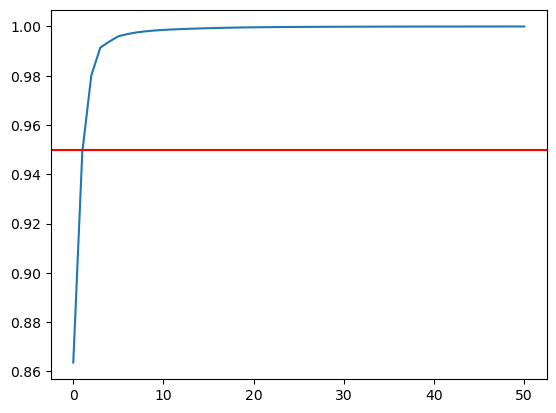

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 2.1172800144884985
Root Mean Squared Error: 1.4550876312059349
R-Squared value: 0.47404200446741973


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
587: 0.0070667616915925605
586: 0.007062374276957779
584: 0.007053403975384134


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:24:40,412] A new study created in memory with name: no-name-e22ab7c8-03d9-4619-a813-73b07d6caa68
[I 2024-03-07 15:24:41,591] Trial 0 finished with value: 4.66562061388563 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 4.66562061388563.
[I 2024-03-07 15:24:42,345] Trial 1 finished with value: 5.360765640680346 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 4.66562061388563.
[I 2024-03-07 15:24:42,779] Trial 2 finished with value: 5.18924814982483 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 4.66562061388563.
[I 2024-03-07 15:24:43,812] Trial 3 finished with value: 3.9261405078245857 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 3.9261405

[I 2024-03-07 15:25:26,131] Trial 36 finished with value: 4.180979874430345 and parameters: {'n_estimators': 79, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 21 with value: 3.2458012428945318.
[I 2024-03-07 15:25:26,747] Trial 37 finished with value: 5.116347159957934 and parameters: {'n_estimators': 96, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 21 with value: 3.2458012428945318.
[I 2024-03-07 15:25:27,288] Trial 38 finished with value: 4.6414719071755846 and parameters: {'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 3.2458012428945318.
[I 2024-03-07 15:25:29,608] Trial 39 finished with value: 3.699729102843874 and parameters: {'n_estimators': 84, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 21 with value: 3.2458012428945318.
[I 2024-03-07 15:25:32,649] Trial 40 finished with value: 4.551778293716174 and paramete

[I 2024-03-07 15:26:15,403] Trial 73 finished with value: 3.166980811035334 and parameters: {'n_estimators': 65, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 71 with value: 3.165816248200334.
[I 2024-03-07 15:26:16,280] Trial 74 finished with value: 4.285965398399703 and parameters: {'n_estimators': 55, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 71 with value: 3.165816248200334.
[I 2024-03-07 15:26:17,560] Trial 75 finished with value: 3.299470934646354 and parameters: {'n_estimators': 65, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 71 with value: 3.165816248200334.
[I 2024-03-07 15:26:18,996] Trial 76 finished with value: 3.3837289764628866 and parameters: {'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 71 with value: 3.165816248200334.
[I 2024-03-07 15:26:19,965] Trial 77 finished with value: 4.492384505371789 and parameters: {'n_

Best trial:
  Value: 3.040255446292036
  Params: 
    n_estimators: 54
    max_depth: 7
    min_samples_split: 12
    min_samples_leaf: 1
Mean Squared Error: 3.4413045380276768
Root Mean Squared Error: 1.8550753456470916
R-Squared value: 0.14513827908800614


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
354: 0.16937505810252912
355: 0.04619489578983446
352: 0.04441523255473921


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-07 15:27:02,611] A new study created in memory with name: no-name-09ebdec5-7fe8-4960-9e48-b433d4a56787
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:27:09,545] Trial 0 finished with value: 2.8887411274266372 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 2.8887411274266372.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:28:09,858] Trial 14 finished with value: 2.7675334161835727 and parameters: {'n_estimators': 77, 'max_depth': 5, 'learning_rate': 0.0978144269260402}. Best is trial 9 with value: 2.417349265583004.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:28:11,988] Trial 15 fini

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:28:43,499] Trial 28 finished with value: 2.8228068836387923 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.07000566642494314}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:28:48,637] Trial 29 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:29:21,817] Trial 42 finished with value: 2.337646350034252 and parameters: {'n_estimators': 119, 'max_depth': 4, 'learning_rate': 0.07868931033981882}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:29:24,100] Trial 43 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:29:54,955] Trial 56 finished with value: 2.43621216733674 and parameters: {'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.07635329403714176}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:29:57,144] Trial 57 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:30:27,977] Trial 70 finished with value: 2.6886211549158627 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.09353135016417909}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:30:30,426] Trial 71 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:30:59,337] Trial 84 finished with value: 2.613751435052348 and parameters: {'n_estimators': 86, 'max_depth': 4, 'learning_rate': 0.0883602737346478}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:31:01,675] Trial 85 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:31:32,420] Trial 98 finished with value: 2.2068918996726397 and parameters: {'n_estimators': 55, 'max_depth': 4, 'learning_rate': 0.09493806579690717}. Best is trial 17 with value: 2.0548978258854227.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:31:33,707] Trial 99 f

Best trial:
  Value: 2.0548978258854227
  Params: 
    n_estimators: 98
    max_depth: 4
    learning_rate: 0.08105750915615716
Mean Squared Error: 2.2653696832327532
Root Mean Squared Error: 1.5051145083457116
R-Squared value: 0.4372547374083535


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
354: 0.1112809410542927
373: 0.06332674768065465
662: 0.06238083562054768


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:31:36,064] A new study created in memory with name: no-name-9324963e-892c-4dbe-9a57-43a2cd844e8c
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-03-07 15:31:40,173] Trial 6 finished with value: 5.128204750294042 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 2 with value: 2.327828755969946.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:31:49,527] Trial 19 finished with value: 2.5550747095987174 and parameters: {'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.09768859110891426, 'min_child_weight': 2, 'subsample': 0.8805827658759505, 'colsample_bytree': 0.7772144339215246}. Best is trial 17 with value: 2.2629409814295216.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:32:01,426] Trial 32 finished with value: 2.8493611777360783 and parameters: {'n_estimators': 78, 'max_depth': 9, 'learning_rate': 0.06646838337076168, 'min_child_weight': 2, 'subsample': 0.7213850575310954, 'colsample_bytree': 0.5557986859735957}. Best is trial 17 with value: 2.2629409814295216.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:32:15,709] Trial 45 finished with value: 2.6119882713872493 and parameters: {'n_estimators': 135, 'max_depth': 10, 'learning_rate': 0.08627179387660107, 'min_child_weight': 2, 'subsample': 0.6933175960164499, 'colsample_bytree': 0.9665162685506193}. Best is trial 38 with value: 2.178284161941575.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:32:32,326] Trial 58 finished with value: 4.540698870619155 and parameters: {'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.07534477647898268, 'min_child_weight': 6, 'subsample': 0.7687317827315245, 'colsample_bytree': 0.8486667481766695}. Best is trial 38 with value: 2.178284161941575.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:33:00,102] Trial 71 finished with value: 2.8118278227476683 and parameters: {'n_estimators': 123, 'max_depth': 9, 'learning_rate': 0.09257625386572563, 'min_child_weight': 2, 'subsample': 0.7939406314744321, 'colsample_bytree': 0.8339748512188958}. Best is trial 68 with value: 2.0079545426115546.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:33:31,621] Trial 84 finished with value: 3.1928035385813502 and parameters: {'n_estimators': 138, 'max_depth': 10, 'learning_rate': 0.08416022456223644, 'min_child_weight': 3, 'subsample': 0.8563664611291691, 'colsample_bytree': 0.6499720201126035}. Best is trial 81 with value: 1.6423813422918956.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:34:03,567] Trial 97 finished with value: 2.025342516460149 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.09315811040227293, 'min_child_weight': 3, 'subsample': 0.9395843770970971, 'colsample_bytree': 0.6287146637021972}. Best is trial 81 with value: 1.6423813422918956.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34544/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

Best trial:
  Value: 1.6423813422918956
  Params: 
    n_estimators: 136
    max_depth: 10
    learning_rate: 0.09978907379837829
    min_child_weight: 3
    subsample: 0.9467419800594683
    colsample_bytree: 0.6985642021090714
Mean Squared Error: 1.6423813422918956
Root Mean Squared Error: 1.2815542681805931
R-Squared value: 0.5920125855905554


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
644: 0.08568614721298218
1575: 0.07923337072134018
1887: 0.06107812374830246
